In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
# using BenchmarkTools
import ProgressMeter
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1317


In [2]:
# Multivariate update
ReactiveMP.@rule NormalMixture{N}(:out, Marginalisation) (q_switch::Any, q_m::NTuple{N,  MultivariateNormalDistributionsFamily}, q_p::NTuple{N, Wishart }) where { N } = begin
    πs = probvec(q_switch)
    d  = ndims(first(q_m))
    w  = mapreduce(x -> x[1]*mean(x[2]), +, zip(πs, q_p))
    xi = mapreduce(x -> x[1]*mean(x[2])*mean(x[3]), +, zip(πs, q_p, q_m))
    return MvNormalWeightedMeanPrecision(xi, w)
end

In [3]:
using Optim

function my_optimizer(::Type{ Univariate }, ::Type{ Continuous }, constraint::PointMassFormConstraint, distribution)
    target = let distribution = distribution 
        (x) -> -logpdf(distribution, x[1])
    end
    support = Distributions.support(distribution)
    result = if isinf(Distributions.minimum(support)) && isinf(Distributions.maximum(support))
        optimize(target, call_starting_point(constraint, distribution), LBFGS(), Optim.Options(iterations = 5))
    else
        lb = [ Distributions.minimum(support) ]
        rb = [ Distributions.maximum(support) ]
        optimize(target, lb, rb, call_starting_point(constraint, distribution), Fminbox(GradientDescent()), Optim.Options(iterations = 5))
    end
    return PointMass(Optim.minimizer(result)[1])
end

my_optimizer (generic function with 1 method)

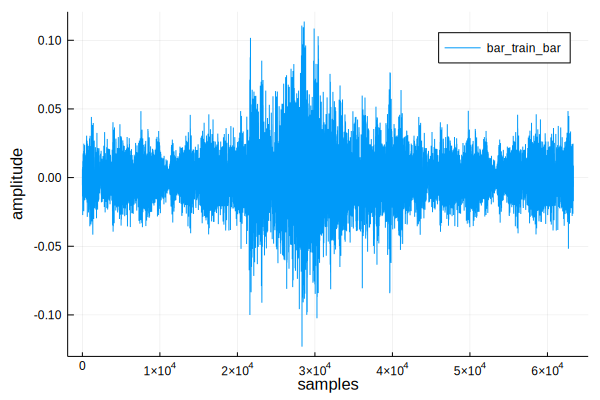

In [4]:
using WAV
# load clean speech
file_name = "bar_train_bar"
bkb, fs = wavread("sound/switching_context/$(file_name).wav")
plot(bkb, label=file_name, xlabel="samples", ylabel="amplitude")

## Switching AR

In [5]:
@model [ default_factorisation = MeanField() ] function switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                     priors_as, priors_bs,
                                                                     priors_ms, priors_ws)

    n = length(outputs)
    A ~ MatrixDirichlet([0.6 0.4; 0.3 0.7])

    z_0 ~ Categorical(fill(1.0 / nmixtures, nmixtures))

    as = randomvar(nmixtures, prod_constraint = ProdGeneric(), form_constraint = PointMassFormConstraint(optimizer = my_optimizer, starting_point = (_, _, _, dist) -> [ mean(ReactiveMP.getleft(dist)) ]))
    bs = randomvar(nmixtures)
    ms = randomvar(nmixtures)
    ws = randomvar(nmixtures)

    for i in 1:nmixtures
        as[i] ~ GammaShapeRate(shape(priors_as[i]), rate(priors_as[i]))
        bs[i] ~ GammaShapeRate(shape(priors_bs[i]), rate(priors_bs[i]))
        ms[i] ~ MvNormalMeanCovariance(mean(priors_ms[i]), cov(priors_ms[i]))
        ws[i] ~ Wishart(priors_ws[i][1], priors_ws[i][2])
    end

    z  = randomvar(nbuckets)
    γ  = randomvar(nbuckets)
    θ  = randomvar(nbuckets)
    dp = randomvar(n)
    x  = datavar(Vector{Float64}, n)
    y  = datavar(Float64, n)

    tas = tuple(as...)
    tbs = tuple(bs...)
    tms = tuple(ms...)
    tws = tuple(ws...)

    z_prev = z_0
    for i in 1:nbuckets
        z[i] ~ Transition(z_prev, A) where { q = q(out, in)q(a) }
        γ[i] ~ GammaMixture(z[i], tas, tbs)
        θ[i] ~ GaussianMixture(z[i], tms, tws) where { q = MeanField() }
        z_prev = z[i]
    end
    
    k = div(n + ARorder, nbuckets)

    for i in 1:n
        r     = clamp(div(i - 1, k) + 1, 1, nbuckets)
        dp[i] ~ dot(x[i], θ[r])
        y[i]  ~ NormalMeanPrecision(dp[i], γ[r]) 
    end

    scheduler = schedule_updates(as, bs, ms, ws)
#     scheduler = schedule_updates(ms, ws, as, bs, z, θ, γ, A)

    return scheduler, z, A, as, bs, ms, ws, θ, γ, y, x
end

switching_ar (generic function with 1 method)

In [6]:
function inference_ar(inputs, outputs, nmixtures, nbuckets, n_its, priors_as, priors_bs, priors_ms, priors_ws)
    n = length(outputs)
    ARorder = size(priors_ms[1])[1]

    model, (scheduler, z, A, as, bs, ms, ws, θs, γs, y, x) = switching_ar(inputs, outputs, nmixtures, nbuckets,
                                                                          priors_as, priors_bs,
                                                                          priors_ms, priors_ws, options=(limit_stack_depth=100,));
    

    mzs     = keep(Vector{Marginal})
    mA      = keep(Marginal)
    mas     = keep(Vector{Marginal})
    mbs     = keep(Vector{Marginal})
    mms     = keep(Vector{Marginal})
    mws     = keep(Vector{Marginal})
    mθs     = keep(Vector{Marginal})
    mγs     = keep(Vector{Marginal})
    fe      = ScoreActor(Float64)

    mA_sub     = subscribe!(getmarginal(A), mA)
    mz_sub     = subscribe!(getmarginals(z), mzs)
    as_sub     = subscribe!(getmarginals(as), mas)
    bs_sub     = subscribe!(getmarginals(bs), mbs)
    ms_sub     = subscribe!(getmarginals(ms), mms)
    ws_sub     = subscribe!(getmarginals(ws), mws)
    θs_sub     = subscribe!(getmarginals(θs), mθs)
    γs_sub     = subscribe!(getmarginals(γs), mγs)

    # fe_scheduler = PendingScheduler()
    fe_sub     = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    setmarginal!(A, vague(MatrixDirichlet, (nmixtures, nmixtures)))

    for (i, (a, b, m, w)) in enumerate(zip(as, bs, ms, ws))
        setmarginal!(a, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(b, infgamma(Float64, 1.0, ϵ = 1.0))
        setmarginal!(m, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(w, vague(Wishart, ARorder))
    end

    for (θ, γ) in zip(θs, γs)
        setmarginal!(θ, vague(MvNormalMeanCovariance, ARorder))
        setmarginal!(γ, vague(Gamma))
    end

    release!(scheduler)
    
    ProgressMeter.@showprogress for i in 1:n_its
        update!(x, inputs)
        update!(y, outputs)
        release!(scheduler)
        # release!(fe_scheduler)
    end


    return map(getvalues, (mzs, mγs, mθs, mA, mas, mbs, mms, mws, fe))
end

inference_ar (generic function with 1 method)

In [7]:
ReactiveMP.release!(::Nothing) = nothing

In [8]:
# cherry picking
# seed 22
γs = [1.0, 0.1]
θs = [[0.3, 0.1], [0.1, -0.2]]

γs = [1.0, 1.0]
θs = [[-0.3, 0.5], [0.1, -0.2]]

2-element Vector{Vector{Float64}}:
 [-0.3, 0.5]
 [0.1, -0.2]

## Generate AR

In [9]:
using Random
Random.seed!(22)

infgamma(T, x; ϵ = 1e-3) = GammaShapeRate{T}(x^2 / ϵ, x / ϵ)

using Distributions

γs = [80082, 34003]
# γs = [1.0, 0.1]
θs = [[1.25166, -0.423974], [1.04586, -0.198375]]
# θs = [randn(2), randn(2)]
# γs = [1.0, 0.1]
# θs = [[0.3, 0.1], [0.1, -0.2]]
# θs = [[0.3, 0.1, -0.2], [0.1, -0.2, -0.5]]
ARorder = length(first(θs))

@assert length(γs) == length(θs)

nmixtures = length(γs)
n_samples = 5000
x = 0.1*ones(ARorder)
# x = [1.0, 2.0]

n_slice_n = 500

for i in 1:n_samples
    i_mixture = rem(div(i, n_slice_n), nmixtures) + 1
    dist = Normal(dot(θs[i_mixture], x[end:-1:end-ARorder+1]), sqrt(1/γs[i_mixture]))
    push!(x, rand(dist))
end
inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

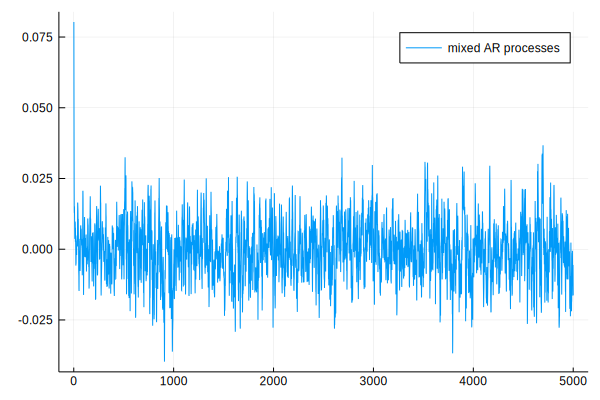

In [10]:
plot(outputs, label="mixed AR processes")

In [11]:
using Random
Random.seed!(22)
x = bkb[1:25:end]
n_samples = length(x)-1

inputs = x[1:n_samples+1]
outputs = circshift(x, -1)

inputs = inputs[1:end-1]
outputs = outputs[2:end-1]
;

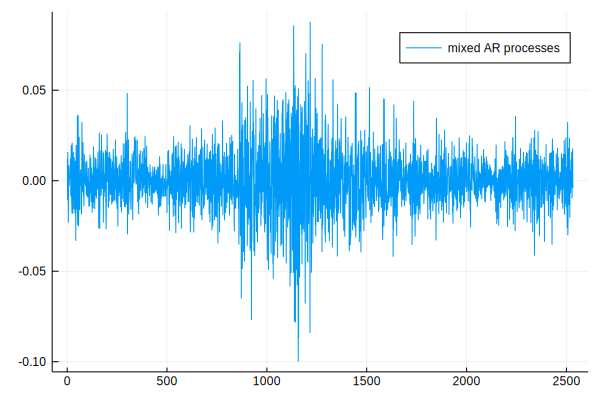

In [12]:
plot(outputs, label="mixed AR processes")

┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1317


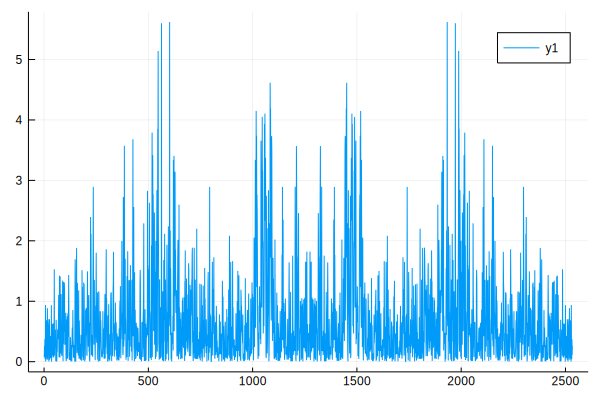

In [13]:
using FFTW
plot(abs.(fft(outputs)).^2)

In [315]:
using FFTW
plot(abs.(fft(bkb)).^2)

In [14]:
inputs_ = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
outputs_ = outputs[1:size(inputs_, 1)]

2532-element Vector{Float64}:
  0.011932737205114903
 -0.010803552354503006
  0.015808587908566547
  0.0030823694570757164
 -0.0025025177770317698
 -0.023194067201757866
  0.006073183385723441
  0.00848414563432722
 -0.0005493331705679495
 -0.003021332438123722
  0.0015564439832758568
  0.002380443739127781
  0.0011597033600878933
  ⋮
 -0.006012146366771447
  0.0038758507034516434
  0.01174962614825892
 -0.0032654805139316996
 -0.003204443494979705
  0.016022217474898525
  0.0019837031159398175
 -0.009857478560747094
 -0.0019531846064638203
  0.0097964415417951
  0.017731254005554368
 -0.0012512588885158849

In [33]:
# csep = 1000.0

priors_as = map(γ -> infgamma(Float64, γ), γs)
priors_bs = map(_ -> infgamma(Float64, 1.0), γs)

priors_ms = map(θ -> MvGaussianMeanPrecision(θ[1], θ[2]), zip(θs, [diageye(ARorder), diageye(ARorder)]))
priors_ws = map(_ -> (ARorder, diageye(ARorder)), θs)

# mixing = [0.5, 0.5]
# dists = [convert(Gamma, GammaShapeRate{Float64}(γs[j]*1e2, 1e2)) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Gamma[dists... ], mixing), 10000), bins=100)
#
# dists = [Normal(θs[j], sqrt(inv(1e4))) for j in 1:length(mixing)]
# p = histogram(rand(MixtureModel(Normal[dists... ], mixing), 10000), bins=100)

# ReactiveMP.is_clamped(tuple::Tuple) = all(ReactiveMP.is_clamped, collect(tuple))
# ReactiveMP.is_initial(tuple::Tuple) = all(ReactiveMP.is_initial, collect(tuple))

@time mzs, mγs, mθs, mA, mas, mbs, mms, mws, mfe = inference_ar(inputs_, outputs_, nmixtures, 50, 150, priors_as, priors_bs, priors_ms, priors_ws);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


 34.216196 seconds (246.89 M allocations: 14.325 GiB, 14.29% gc time, 0.19% compilation time)


In [34]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.689593  0.0546955
 0.310407  0.945304

In [35]:
minimum(mean.(mγs[end]))

33451.59969062881

In [36]:
mean.(mθs[end])

50-element Vector{Vector{Float64}}:
 [-0.02886532206529216, -0.23419268742234212]
 [0.12966003564053263, -0.527866378961057]
 [0.1800441733339173, -0.4313241248292804]
 [0.11728212749010827, -0.2532270232697405]
 [0.028224934437870438, -0.06446517695164604]
 [-0.2409141405247369, -0.34061036766755864]
 [0.06305010285032335, 0.3113578753521284]
 [-0.14857453858292813, 0.07652297847112016]
 [-0.26866993500307246, 0.06317179022960648]
 [-0.13401440398825096, 0.049462875271017934]
 [-0.16143646712278034, -0.34092715472294066]
 [0.023408742979516756, -0.3579896225224581]
 [-0.16447884457993803, -0.45392084914744535]
 ⋮
 [0.0779906984283857, -0.19029480027023365]
 [-0.029197882829428708, -0.44323812100348925]
 [0.11625275656371396, 0.35110942019758995]
 [-0.30373750284744816, -0.03338754749131924]
 [-0.14998071774179872, -0.06335897675555142]
 [-0.1327524521079097, 0.13451013322546868]
 [-0.059420691910602445, -0.38745259837817336]
 [0.12878775333919698, -0.43317957697873105]
 [-0.3163949183

In [37]:
using Plots

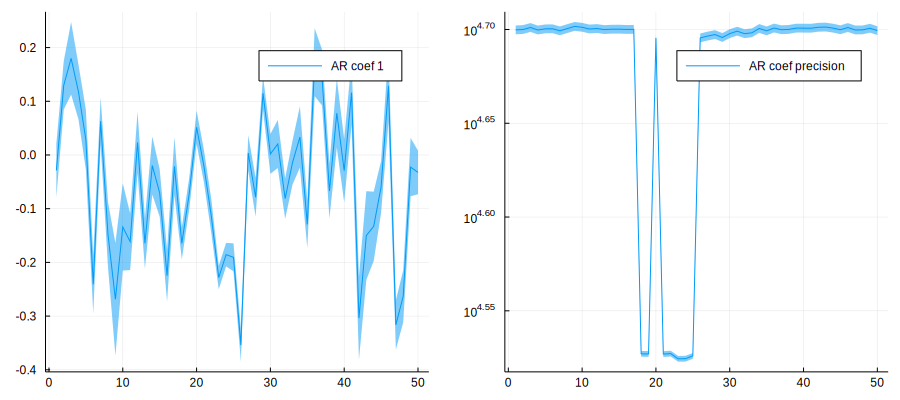

In [38]:
dim(n) = (x) -> map(i -> i[n], x)
index = 1
p1 = plot(mean.(mθs[end]) |> dim(index), ribbon = std.(mθs[end]) |> dim(index), label="AR coef $(index)")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")

plot(p1, p2, size = (900, 400))

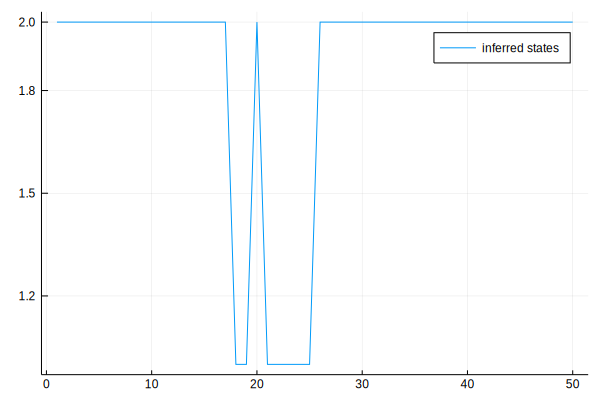

In [39]:
plot(mean.(mzs[end][1:end]), label="inferred states")

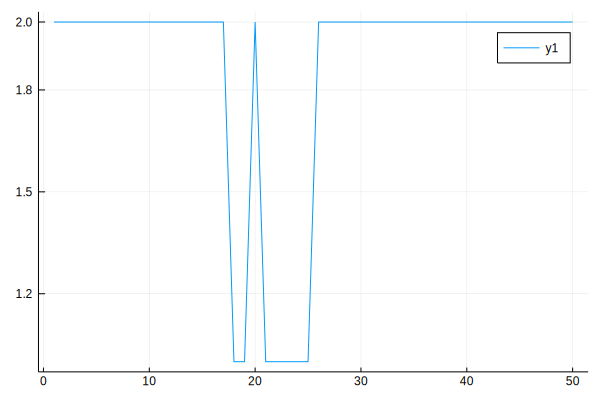

In [40]:
plot(round.(mean.(mzs[end])))

In [41]:
mean.(mzs[end])

50-element Vector{Float64}:
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 ⋮
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987168
 1.9999999999987503

mfe[end - 4:end] = [2794.5889727558406, 2733.640331823156, 2673.7262195289077, 2614.8185927060385, 2556.90055946787]


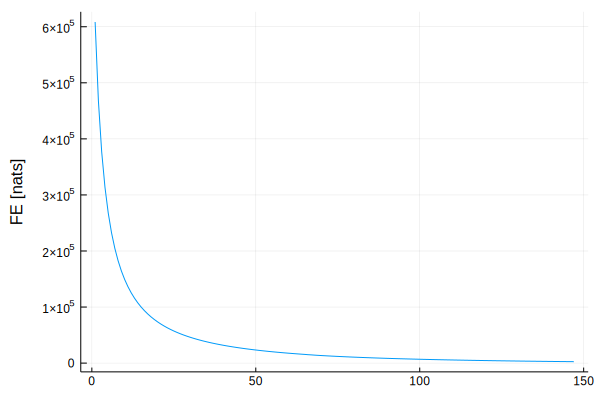

In [42]:
@show mfe[end-4:end]
plot(mfe[4:end], label=:none, ylabel="FE [nats]")